In [ ]:
# Import libraries

In [1]:
import requests 
import pandas as pd
import numpy as np
import scipy.stats as si
import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define pricing functions

In [3]:
def BS_Price(S, K, T, r, sigma, p_c):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if p_c == 'C':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif p_c == 'P':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [4]:
def BS_IV(S, K, T, r, price, p_c):
    
    finalIV = 1
    dIV = 0.01
    thresholdPx = 0.001
    
    for i in range(100):
        thisPx = BS_Price(S, K, T, r, finalIV, p_c)
        dPx = BS_Price(S, K, T, r, finalIV + dIV, p_c) - thisPx
        finalIV = finalIV + (price - thisPx) / dPx * dIV
        if dPx <= thresholdPx:
            break
            
    return finalIV

In [5]:
def d1(S, K, T, r, sigma):
    
    return (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))

In [6]:
def delta_call(S, K, T, r, sigma):
    
    N = norm.cdf
    
    return N(d1(S, K, T, r, sigma))

In [7]:
def delta_put(S, K, T, r, sigma):
    
    N = norm.cdf
    
    return -N(-d1(S, K, T, r, sigma))

In [8]:
# Function to convert ddmmmyy date format to days from today

In [9]:
def Date_reformat(date_ddmmmyy):
    
    return (datetime.datetime.strptime(date_ddmmmyy + 'UTC08', '%d%b%y%Z%H') - datetime.datetime.utcnow()).total_seconds() / 86400


In [10]:
# Define function to call Deribit, reformat output and calculate Ivol

In [11]:
def Get_option_data(asset):
    
    url_option_data = f'https://www.deribit.com/api/v2/public/get_book_summary_by_currency?currency={asset}&kind=option'
    json_option_data = requests.get(url = url_option_data).json() 
    result_option_book = json_option_data['result']
    
    for i in result_option_book:
        instrument_name = i['instrument_name']
        instrument_data = instrument_name.split("-")
        underlying = instrument_data[0]
        expiry = instrument_data[1]
        strike = float(instrument_data[2])
        putcall = instrument_data[3]
        TTE = Date_reformat(expiry)/365.25
        underlying_price = float(i['underlying_price'])
        bid_price = i['bid_price']
        ask_price = i['ask_price']
        mid_price = i['mid_price']

        if bid_price == None:
            i['bid_IV'] = None
        else:
            i['bid_IV'] = BS_IV(underlying_price,strike,TTE,0,float(bid_price)*underlying_price,putcall)

        if ask_price == None:
            i['ask_IV'] = None
        else:
            i['ask_IV'] = BS_IV(underlying_price,strike,TTE,0,float(ask_price)*underlying_price,putcall)

        if mid_price == None:
            i['mid_IV'] = None
        else:
            i['mid_IV'] = BS_IV(underlying_price,strike,TTE,0,float(mid_price)*underlying_price,putcall)

    return result_option_book


In [12]:
output = Get_option_data('ETH')

In [13]:
# Extract just the data points we need

In [14]:
new_list = []

for i in range(0,len(output)):
    
    a = output[i].get('instrument_name')
    b = output[i].get('open_interest')
    c = a.split("-")[1]
    d = a.split("-")[2]
    e = a.split("-")[3]
    f = output[i].get('mid_IV')
    g = output[i].get('underlying_price')
    h = Date_reformat(c)/365.25
    
    if f == None:
        delta = None
    elif e == 'C':
        delta = delta_call(float(g),float(d),h,0,f)
    elif e == 'P':
        delta = delta_put(float(g),float(d),h,0,f)
    else:
        delta = None
    
    i = delta
    j = {'open_interest': b, 'expiry': c, 'strike': d, 'p_c': e, 'ivol': f, 'fwd_point': g, 'delta': i, 'TTM': h}
    new_list.append(j)
    

In [15]:
new_df = pd.DataFrame(new_list)

In [16]:
# Generate OI bar chart and implied volatility smile for single expiry

In [17]:
# Choose expiry and create a call and a put DataFrame

In [18]:
exp = '21APR23'

plot_data_call = new_df[(new_df['expiry'] == exp) & (new_df['p_c'] == 'C')]
plot_data_put = new_df[(new_df['expiry'] == exp) & (new_df['p_c'] == 'P')]

In [19]:
# Data cleaning/prep steps

In [20]:
plot_data_call.strike = plot_data_call.strike.astype(float).copy()
plot_data_put.strike = plot_data_put.strike.astype(float).copy()
plot_data_call = plot_data_call.sort_values(by='strike', ascending=True)
plot_data_put = plot_data_put.sort_values(by='strike', ascending=True)

In [21]:
plot_data_call = plot_data_call[plot_data_call.strike > plot_data_call['fwd_point'].iloc[0]]
plot_data_put = plot_data_put[plot_data_put.strike < plot_data_put['fwd_point'].iloc[0]]

In [22]:
plot_data_call = plot_data_call.dropna()
plot_data_put = plot_data_put.dropna()

In [23]:
plot_data_total = pd.concat([plot_data_put,plot_data_call])
plot_data_total.index = plot_data_total.strike
plot_data_total_delta = plot_data_total.copy()
plot_data_total_delta.index = plot_data_total.delta

In [24]:
# Plot charts

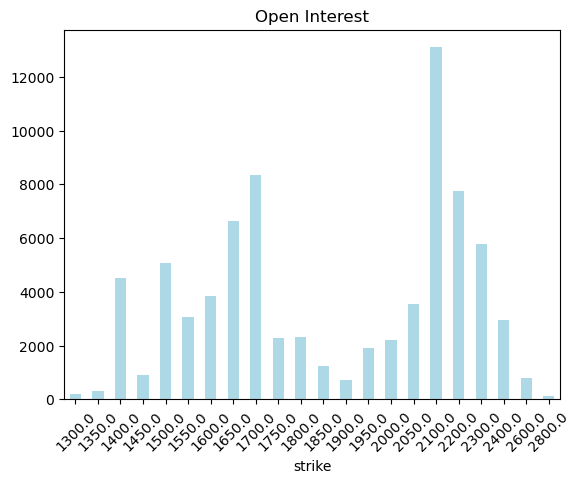

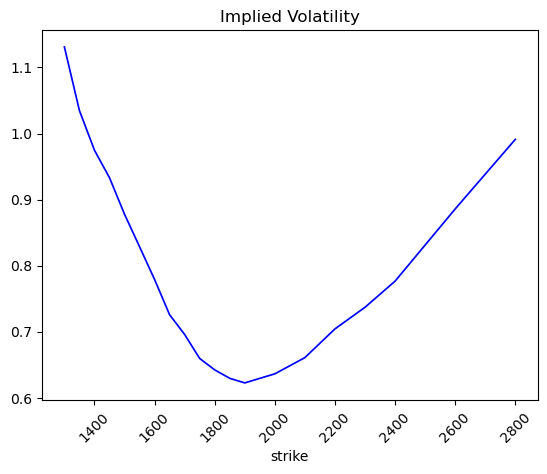

In [25]:
fig, ax = plt.subplots()

plot_data_total['open_interest'].plot(kind='bar', color='lightblue')
ax.grid(False)
ax.title.set_text('Open Interest')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
fig, ax2 = plt.subplots()

plot_data_total['ivol'].plot(kind='line', color='blue', linewidth=1.25)
ax2.grid(False)
ax2.title.set_text('Implied Volatility')
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)

In [26]:
# Generate charts for multiple expiries

In [27]:
# Create list of expiries sorted with shortest tenor first

In [28]:
df_exp_list = new_df.drop_duplicates(subset=['expiry'])
df_exp_list = df_exp_list.sort_values(by='TTM', ascending=True)

In [29]:
exp_list = list(df_exp_list.expiry)

In [30]:
# Create dictionary of cleaned DataFrames per expiry

In [87]:
ivol_list = {}

for i in exp_list:
    plot_data_call = new_df[(new_df['expiry'] == i) & (new_df['p_c'] == 'C')]
    plot_data_put = new_df[(new_df['expiry'] == i) & (new_df['p_c'] == 'P')]
    plot_data_call.strike = plot_data_call.strike.astype(float)
    plot_data_put.strike = plot_data_put.strike.astype(float)
    plot_data_call = plot_data_call[plot_data_call.strike > plot_data_call['fwd_point'].iloc[0]].dropna()
    plot_data_put = plot_data_put[plot_data_put.strike < plot_data_put['fwd_point'].iloc[0]].dropna()
    plot_data_total = pd.concat([plot_data_put,plot_data_call])
    plot_data_total = plot_data_total.sort_values(by='strike', ascending=True)
    plot_data_total.index = plot_data_total.strike
    ivol_list[i] = plot_data_total

In [32]:
# New clean dictionary of DataFrames with just the data we need

In [34]:
new_dict = {}

for a in list(exp_list):
    b = list(exp_list).index(a)
    df_comb = pd.DataFrame(columns=list(ivol_list[a]['strike']))
    df_comb.loc[a] = list(ivol_list[a]['ivol'])
    new_dict[a] = df_comb

In [36]:
# Combine into one DataFrame

In [37]:
list_of_dataframes = list(new_dict.values())
final_df = pd.concat(list_of_dataframes)

In [38]:
final_df = final_df[sorted(list(final_df.columns), key=int)]

In [39]:
final_df = final_df.reindex(exp_list)

In [40]:
# Generate chart for implied volatility surface

Text(0.5, 1.0, 'ETH Implied Volatility')

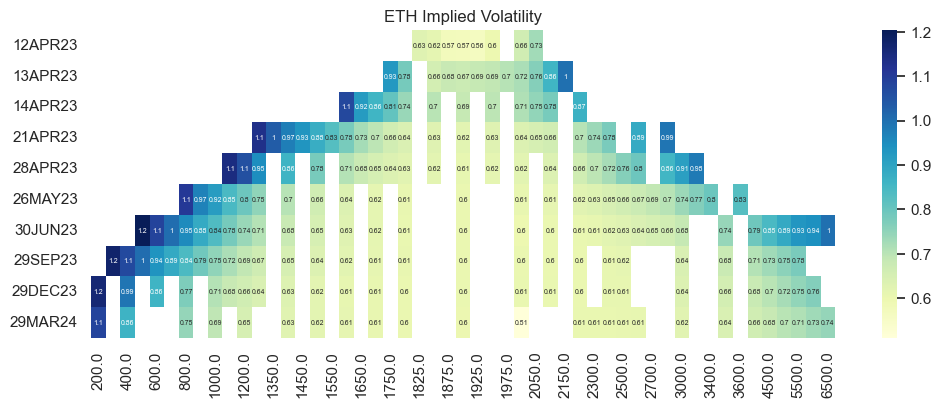

In [41]:
import seaborn as sns

sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(final_df, cmap="YlGnBu", annot=True, annot_kws={"fontsize":5})
sns.set_context("poster",font_scale=0.5)
ax.set_title('ETH Implied Volatility')

In [42]:
# A chart for open interest

In [43]:
# New clean dictionary of DataFrames with just the data we need

In [44]:
oi_dict = {}

for a in list(exp_list):
    b = list(exp_list).index(a)
    df_oi = pd.DataFrame(columns=list(ivol_list[a]['strike']))
    df_oi.loc[a] = list(ivol_list[a]['open_interest'])
    oi_dict[a] = df_oi

In [45]:
# Combine into one DataFrame

In [46]:
list_of_dataframes_oi = list(oi_dict.values())
oi_df = pd.concat(list_of_dataframes_oi)

In [47]:
oi_df = oi_df.reindex(exp_list)

In [48]:
oi_df = oi_df[sorted(list(oi_df.columns), key=int)]

In [49]:
# Generate chart for open interest grid

Text(0.5, 1.0, 'ETH Options Open Interest')

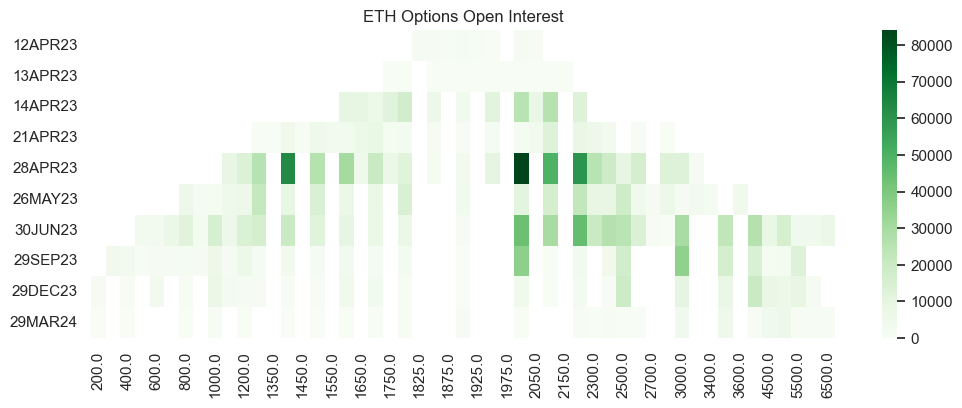

In [50]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(oi_df, cmap="Greens", annot=False, annot_kws={"fontsize":5})
sns.set_context("poster",font_scale=0.5)
ax.set_title('ETH Options Open Interest')

In [51]:
# A chart of basis betweem each calendar futures point

In [52]:
# New clean dictionary of lists with just the forward point and days to expiry

In [53]:
basis_dict = {}

for d in list(ivol_list.keys()):
    basis_dict[d] = [ivol_list[d]['fwd_point'].iloc[0],Date_reformat(d)]

In [54]:
basis_dict_reorder = {k: basis_dict[k] for k in exp_list}

In [55]:
# Calculate annualised basis per calendar spread

In [56]:
basis_dict_2 = {}

for t in list(basis_dict_reorder.keys()):
    b = []
    for a in list(basis_dict_reorder.keys()):
        if (basis_dict_reorder[t][0]-basis_dict_reorder[a][0]) == 0:
            b.append(round(0,2))
        elif basis_dict_reorder[t][1] < basis_dict_reorder[a][1]:
            b.append(None)
        else:
            c = (basis_dict_reorder[t][0]-basis_dict_reorder[a][0])*(365/(basis_dict_reorder[t][1]-basis_dict_reorder[a][1]))
            b.append(round(c/basis_dict_reorder[t][0]*100,2))
    basis_dict_2[t] = b

In [57]:
basis_df = pd.DataFrame(basis_dict_2)

In [58]:
basis_df.index = exp_list

In [59]:
# Generate chart showing basis between each calendar futures point

Text(0.5, 1.0, 'ETH Annualised Futures Basis (%)')

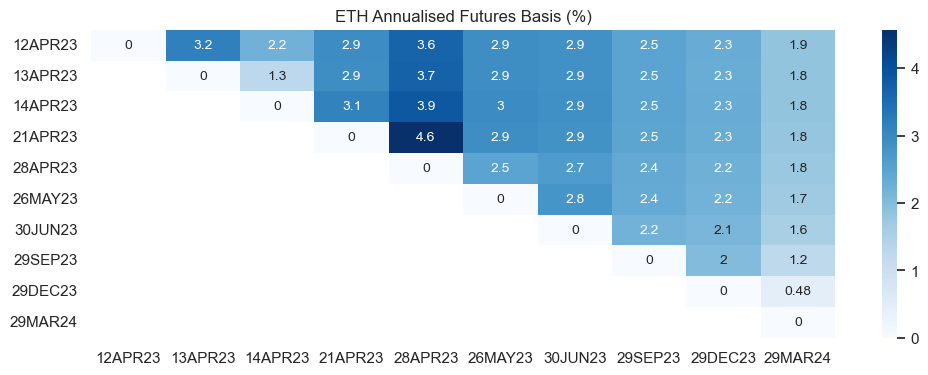

In [60]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(basis_df, cmap="Blues", annot=True, annot_kws={"fontsize":10})
sns.set_context("poster",font_scale=0.5)
ax.set_title('ETH Annualised Futures Basis (%)')

In [61]:
# Futures curve

In [62]:
# Various data handling steps

In [63]:
df_exp_list = df_exp_list.rename({'TTM': 'Days_to_expiry'}, axis=1)
df_exp_list['Days_to_expiry'] = df_exp_list['Days_to_expiry']*365.25
df_exp_list.index = df_exp_list.Days_to_expiry

In [64]:
# Generate chart showing futures curve

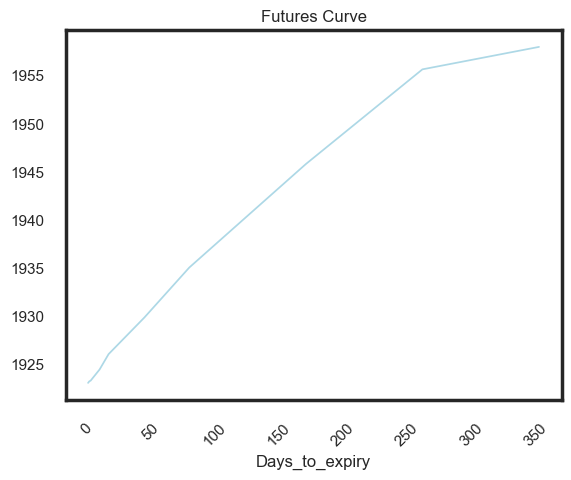

In [65]:
fig, ax3 = plt.subplots()

df_exp_list['fwd_point'].plot(kind='line', color='lightblue', linewidth=1.25)
ax3.grid(False)
ax3.title.set_text('Futures Curve')
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)

In [ ]:
# ATM term structure and risk reversal charts

In [80]:
# Pull ATM volatility, fill the missing deltas and interpolate the implied volatilities

In [81]:
vol_curve = {}

for i in exp_list:
    plot_data_call = new_df.query("expiry == @i and p_c == 'C'").assign(strike=lambda df: df.strike.astype(float)).query("strike > fwd_point.iloc[0]").dropna().sort_values(by='strike', ascending=True)
    plot_data_put = new_df.query("expiry == @i and p_c == 'P'").assign(strike=lambda df: df.strike.astype(float)).query("strike < fwd_point.iloc[0]").dropna().sort_values(by='strike', ascending=False)
    if plot_data_call['TTM'].iloc[0]*365.25 < 1:
        pass
    put_dummy_list = [-i/100 for i in range(1, 31)]
    call_dummy_list = [i/100 for i in range(1, 31)]
    plot_data_put['delta'] = round(plot_data_put['delta'],2)
    plot_data_call['delta'] = round(plot_data_call['delta'],2)
    put_new_deltas = pd.DataFrame({'delta': list(set(put_dummy_list) - set(list(plot_data_put.delta)))})
    call_new_deltas = pd.DataFrame({'delta': list(set(call_dummy_list) - set(list(plot_data_call.delta)))})
    put_combined = pd.concat([plot_data_put, put_new_deltas]).sort_values(by='delta', ascending=False).interpolate(method="linear")
    call_combined = pd.concat([plot_data_call, call_new_deltas]).sort_values(by='delta', ascending=False).interpolate(method="linear")
    vol_curve[i] = {
        'ATM_Implied_Volatility': (plot_data_put['ivol'].iloc[0]+plot_data_call['ivol'].iloc[0])/2,
        '30d_rr': float(put_combined.loc[put_combined['delta'] == -0.30, 'ivol']) - float(call_combined.loc[call_combined['delta'] == 0.30, 'ivol']),
        '25d_rr': float(put_combined.loc[put_combined['delta'] == -0.25, 'ivol']) - float(call_combined.loc[call_combined['delta'] == 0.25, 'ivol']),
        '20d_rr': float(put_combined.loc[put_combined['delta'] == -0.20, 'ivol']) - float(call_combined.loc[call_combined['delta'] == 0.20, 'ivol']),
        '15d_rr': float(put_combined.loc[put_combined['delta'] == -0.15, 'ivol']) - float(call_combined.loc[call_combined['delta'] == 0.15, 'ivol']),
        '10d_rr': float(put_combined.loc[put_combined['delta'] == -0.10, 'ivol']) - float(call_combined.loc[call_combined['delta'] == 0.10, 'ivol']),
        'Tenor': plot_data_put['TTM'].iloc[0]*365.25}

In [82]:
vol_curve_df = pd.DataFrame(vol_curve).T
vol_curve_df.index = vol_curve_df.Tenor

In [ ]:
# Plot ATM implied volatilities

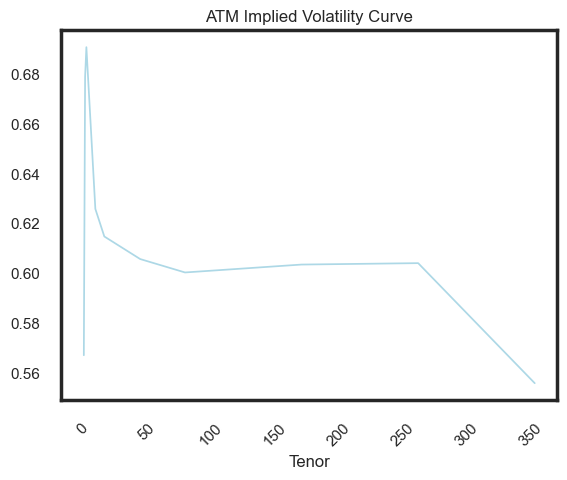

In [83]:
fig, ax4 = plt.subplots()

vol_curve_df['ATM_Implied_Volatility'].plot(kind='line', color='lightblue', linewidth=1.25)
ax4.grid(False)
ax4.title.set_text('ATM Implied Volatility Curve')
for tick in ax4.get_xticklabels():
    tick.set_rotation(45)

In [77]:
rr_df = pd.DataFrame(vol_curve).T
rr_df.index = rr_df.Tenor

In [ ]:
# Plot risk reversals

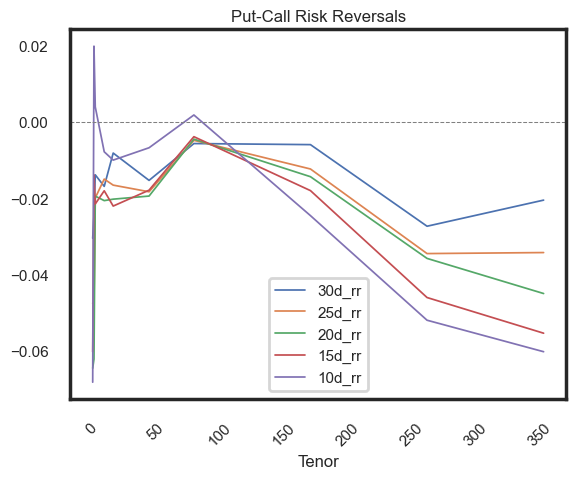

In [84]:
fig, ax5 = plt.subplots()

for i in list(rr_df.columns)[1:-1]:
    rr_df[i].plot(kind='line', linewidth=1.25)

ax5.grid(False)
ax5.title.set_text('Put-Call Risk Reversals')
ax5.legend()
ax5.axhline(y=0, color='grey', linestyle='--', linewidth=0.75)

for tick in ax5.get_xticklabels():
    tick.set_rotation(45)